In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 559

# training hyperparameters
UPDATES = 1000
TRAIN_YEAR = 8
PATIENCE = 10

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
embedding = torch.load("data/final_lstm_embedding.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/camels_train_val.csv",
    record_length=3652,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtrain = dataloader.Forcing_Data(
    "data/camels_train.csv",
    record_length=2922,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "data/camels_val.csv",
    record_length=1095,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "data/camels_test.csv",
    record_length=4383,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

# Start optimization

In [5]:
def get_optimal_update(study):
    
    stats = study.best_trials[0].intermediate_values
    steps = min(stats, key=lambda k: stats[k]) + 1
    
    return steps

In [6]:
class FINE_TUNE:
    def __init__(self, selected_catchment=0, eval_fun=HydroErr.kge_2009):
        self.selected_catchment = selected_catchment
        self.eval_fun=eval_fun
        
    def fine_tune(self,trial):
       
        # define batch size
        batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
        batch_size = 2**batch_size_power
        
        # load model
        decoder = torch.load("data/final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)
        
        # define new embeding for the selected catchment
        embedding = nn.Embedding(1, LATENT_dim).to(computing_device)
        embedding_input = torch.zeros(size = (batch_size,), dtype=torch.long, device=computing_device)

        # validation data
        x_val, y_val = dval.get_catchment_val_batch(self.selected_catchment)
        x_val, y_val = x_val.to(computing_device), y_val.to(computing_device)
        
        # define optimizers
        lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
        embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

        lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)
        
        # model training
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        
        # define early stopper
        early_stopper = training_fun.EarlyStopper(patience=PATIENCE, min_delta=0)
        
        for update in range(UPDATES):
            
            decoder.train()
            embedding.train()
            
            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()
            
            # put the models into training mode
            decoder.train()
            embedding.train()
            
            # get training batch and pass to device
            (x_batch, y_batch, _) = dtrain.get_catchment_random_batch(
                selected_catchment=self.selected_catchment, batch_size=batch_size
            )
            
            x_batch, y_batch = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
            )
            
            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(embedding_input)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = training_fun.mse_loss_with_nans(out, y_batch)
                
            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()

            # validate model after each update
            decoder.eval()
            embedding.eval()
            
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                with torch.no_grad():                    
                    code = embedding(torch.zeros(size = (x_val.shape[0],), dtype=torch.long, device=computing_device))
                    out = decoder.decode(code, x_val)
                    
                    val_loss = training_fun.mse_loss_with_nans(out, y_val).detach().cpu().numpy()
            
            # Handle pruning based on the intermediate value
            trial.report(val_loss, update)

            if trial.should_prune():
                torch.cuda.empty_cache()
                raise optuna.exceptions.TrialPruned()

            # Early stop using early_stopper, break for loop
            if early_stopper.early_stop(val_loss):
                break

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
            
        return early_stopper.min_validation_loss

    def test_final_model(self, n_trials=200, return_model = False):
        
        self.study = optuna.create_study(study_name="fine_tune", direction="minimize", pruner=optuna.pruners.NopPruner())
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        self.study.optimize(self.fine_tune, n_trials = n_trials)
        
        # optimal parameters
        updates = get_optimal_update(self.study)
        
        lr_decoder = self.study.best_params["lr_decoder"]
        lr_embedding = self.study.best_params["lr_embedding"]
        batch_size_power = self.study.best_params["batch_size_power"]
        batch_size = 2 ** batch_size_power

        # load model
        decoder = torch.load("data/final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)
        
        # define new embedding for the selected catchment
        embedding = nn.Embedding(1, LATENT_dim).to(computing_device)
        embedding_input = torch.zeros(size = (batch_size,), dtype=torch.long, device=computing_device)

        # define model optimizer
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)
        embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

        # validation data
        x_test, y_test = dtest.get_catchment_val_batch(self.selected_catchment)
        x_test, y_test = x_test.to(computing_device).contiguous(), y_test.to(computing_device).contiguous()
        
        # start training
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        for update in range(updates):
            
            decoder.train()
            embedding.train()
            
            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()
            
            # put the models into training mode
            decoder.train()
            embedding.train()
            
            # get training batch and pass to device
            (x_batch, y_batch, _) = dtrain_val.get_catchment_random_batch(
                selected_catchment=self.selected_catchment, batch_size=batch_size
            )
            
            x_batch, y_batch = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
            )
            
            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(embedding_input)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = training_fun.mse_loss_with_nans(out, y_batch)
                
            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()
        
        decoder.eval()
        embedding.eval()
        
        with torch.autocast(
            device_type="cuda", dtype=torch.float16, enabled=use_amp
        ):
            with torch.no_grad():                    
                code = embedding(torch.zeros(size = (x_test.shape[0],), dtype=torch.long, device=computing_device))
                pred = decoder.decode(code, x_test).view(-1).detach().cpu().numpy()
                
                ob = y_test.view(-1).detach().cpu().numpy()
                
                gof = self.eval_fun(simulated_array=pred, observed_array=ob)

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        if return_model:
            return gof, embedding, decoder
        else:
            return gof

In [7]:
calibrated_KGES = np.ones(N_CATCHMENTS)

for i in range(N_CATCHMENTS):

    fine_tune = FINE_TUNE(i)
    calibrated_KGES[i], embedding, decoder = fine_tune.test_final_model(n_trials=200, return_model=True)
        
    torch.save(embedding.cpu(), f"data/fine_tune/embedding{i}.pt")
    torch.save(decoder.cpu(), f"data/fine_tune/ecoder{i}.pt")
    
    joblib.dump(fine_tune.study, f"data/fine_tune/study{i}.pkl")


[I 2023-01-11 21:23:24,129] A new study created in memory with name: fine_tune
c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029 4030 4031
 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043 4044 4045
 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057 4058 4059
 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072 4073
 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086 4087
 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099 4100 4101
 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113 4114 4115
 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127 4128 4129
 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141 4142 4143
 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155 4156 4157
 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169 4170 4171
 4172 4173 4174 4175 4176 4177 417

In [8]:
calibrated_KGES

array([ 9.54218269e-01,  8.11622569e-01,  8.38468636e-01,  8.98815595e-01,
        8.74192556e-01,  7.88224383e-01,            -inf,  8.42629996e-01,
        9.31827136e-01,  9.26296478e-01,  7.64779545e-01,  8.12631643e-01,
        8.72957926e-01,  7.11989348e-01,  8.67060093e-01,  7.99651637e-01,
        8.60920194e-01,  8.96567433e-01,  7.07621627e-01,  7.67831474e-01,
        7.42835202e-01,  8.57891300e-01,  5.17352432e-01,  6.73915300e-01,
        8.49930805e-01,  6.86605690e-01,  8.01798471e-01,  5.82533001e-01,
        8.50537332e-01,  8.14062762e-01,  8.27264444e-01,  8.38849573e-01,
        7.02512023e-01,            -inf,  8.53369415e-01,  8.91727744e-01,
        8.24684196e-01,  7.59362095e-01,  7.93227559e-01,  8.16988366e-01,
        8.04394901e-01,  5.12223471e-01,  8.21856233e-01,  7.49875860e-01,
        7.55278985e-01,  8.30614259e-01,  8.82011354e-01,  8.93942826e-01,
        6.28285376e-01,  3.44952268e-01,  6.97872846e-01,  7.43325343e-01,
        6.92894095e-01,  

In [9]:
np.savetxt("data/ft_KGEs.csv", calibrated_KGES, delimiter=",")

In [10]:
calibrated_KGES.mean()

nan

In [11]:
np.median(calibrated_KGES)

nan

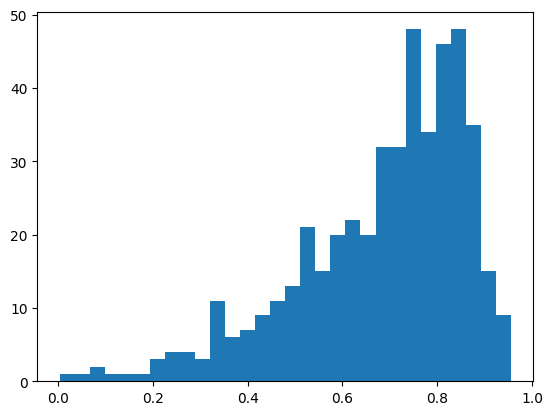

In [12]:
from matplotlib import pyplot as plt

plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()